In [1]:
import pandas as pd
from IPython.display import clear_output
from services import MySQLService
from helpers.stats import get_match_info, get_game_data
from helpers.file import save_file, parse_df_to_csv
from helpers.elo import update_elo, reset_season_elo
from helpers.feature_engineer import (
    get_team_defensive_rating_game,
    get_team_offensive_rating_game,
)

In [21]:
first_season = 2012
last_season = 2023

mysql = MySQLService()

n_last_games = 15
n_last_specific_games = 5

pd.options.mode.chained_assignment = None  # default='warn'

In [22]:
season_games = mysql.execute_query(f"SELECT * from `nba-data`.games WHERE season >= {first_season} and season <= {last_season} ORDER BY date ASC;")
season_games_plyrs = mysql.execute_query(f"SELECT g.id as game_id, g.date, g.season, g.is_playoff, g.winner, g.home_id, g.away_id, pg.team_id, pg.player_id, pg.minutes, pg.pts, pg.fgm, pg.fga, pg.fg_pct, pg.fg3m, pg.fg3a, pg.fg3_pct, pg.ftm, pg.fta, pg.ft_pct, pg.oreb, pg.dreb, pg.reb, pg.ast, pg.stl, pg.blk, pg.tov, pg.pf, pg.plus_minus FROM player_games AS pg LEFT JOIN games as g on pg.game_id = g.id WHERE g.season >= {first_season} and g.season <= {last_season} ORDER BY g.date ASC")
teams = mysql.execute_query(f"SELECT * FROM teams")

C:\Users\caiog\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\caiog\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\caiog\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [23]:
season_games['home_off_rtg'] = season_games.apply(lambda row: get_team_offensive_rating_game(row, 'H'), axis = 1)
season_games['home_def_rtg'] = season_games.apply(lambda row: get_team_defensive_rating_game(row, 'H'), axis = 1)

season_games['away_off_rtg'] = season_games.apply(lambda row: get_team_offensive_rating_game(row, 'A'), axis = 1)
season_games['away_def_rtg'] = season_games.apply(lambda row: get_team_defensive_rating_game(row, 'A'), axis = 1)

In [24]:
display(season_games.head(2))
display(season_games_plyrs.head(2))
display(teams.head(2))

,id,date,season,is_playoff,winner,home_id,home_team,home_pts,home_fgm,home_fga,...,away_stl,away_blk,away_tov,away_pf,home_odds,away_odds,home_off_rtg,home_def_rtg,away_off_rtg,away_def_rtg
0,21200001,2012-10-30,2012,0,H,1610612739,Cleveland Cavaliers,94,36,79,...,11,10,13,19,1.41,2.93,103.524229,92.511013,90.322581,101.075269
1,21200002,2012-10-30,2012,0,H,1610612748,Miami Heat,120,43,79,...,4,2,16,23,1.35,3.26,126.582278,112.869198,112.394958,126.050420


,game_id,date,season,is_playoff,winner,home_id,away_id,team_id,player_id,minutes,...,ft_pct,oreb,dreb,reb,ast,stl,blk,tov,pf,plus_minus
0,21200003,2012-10-30,2012,0,A,1610612747,1610612742,1610612742,203109,19,...,0.0,0,3,3,2,1,0,0,1,2
1,21200002,2012-10-30,2012,0,H,1610612748,1610612738,1610612738,203096,8,...,0.0,0,1,1,0,0,0,0,1,-3


,id,name,abbreviation
0,1610612737,Atlanta Hawks,ATL
1,1610612738,Boston Celtics,BOS


In [25]:
teams_elo_dict = dict()

for i, team in teams.iterrows():
    teams_elo_dict[team['id']] = 1500

In [26]:
print("Creating CSV file of all games...")

teams_per = dict()

matches_organized = []
matches_organized_playoffs = []
season = ""

season_games_iterr = season_games.loc[season_games["season"] >= first_season]
season_games_iterr.reset_index(drop=True, inplace=True)

for i, g in season_games_iterr.iterrows():
    clear_output(wait=True)
    print(f"{i}/{len(season_games_iterr.index)}")

    if season != g["season"]:
        reset_season_elo(teams_elo_dict)

        if g["season"] == 2023:
            save_file("elo", teams_elo_dict, "elo_dict")

    season = g["season"]

    is_playoffs = int(g["is_playoff"])

    team_a_id = g["home_id"]
    team_b_id = g["away_id"]

    team_a_abbv = teams.loc[teams["id"] == team_a_id].iloc[0]["abbreviation"]
    team_b_abbv = teams.loc[teams["id"] == team_b_id].iloc[0]["abbreviation"]

    winner = g["winner"]

    # Update ELO after stats computed
    team_a_pts = g["home_pts"]
    team_b_pts = g["away_pts"]

    team_a_odds, team_b_odds = g["home_odds"], g["away_odds"]

    if not team_a_odds or not team_b_odds:
        update_elo(
            winner,
            teams_elo_dict,
            team_a_id,
            team_b_id,
            team_a_pts,
            team_b_pts,
        )
        continue

    stats_team_a = get_game_data(
        season_games,
        season_games_plyrs,
        teams_elo_dict,
        g,
        team_a_id,
        team_b_id,
        teams_per,
        n_last_games,
        n_last_specific_games,
        "H",
    )
    if not stats_team_a:
        update_elo(
            winner,
            teams_elo_dict,
            team_a_id,
            team_b_id,
            team_a_pts,
            team_b_pts,
        )
        continue

    stats_team_b = get_game_data(
        season_games,
        season_games_plyrs,
        teams_elo_dict,
        g,
        team_b_id,
        team_a_id,
        teams_per,
        n_last_games,
        n_last_specific_games,
        "A",
    )
    if not stats_team_b:
        update_elo(
            winner,
            teams_elo_dict,
            team_a_id,
            team_b_id,
            team_a_pts,
            team_b_pts,
        )
        continue

    update_elo(
        winner,
        teams_elo_dict,
        team_a_id,
        team_b_id,
        team_a_pts,
        team_b_pts,
    )

    match_info = get_match_info(
        [season, g["date"], team_a_abbv, team_b_abbv, team_a_odds, team_b_odds],
        stats_team_a,
        stats_team_b,
        winner,
        team_a_pts,
        team_b_pts,
    )
    if is_playoffs:
        matches_organized_playoffs.append(match_info)
    else:
        matches_organized.append(match_info)

14791/14792


In [27]:
print(
    "Total matches: {}\nTotal playoffs matches: {}".format(
        len(matches_organized), len(matches_organized_playoffs)
    )
)

Total matches: 11049
Total playoffs matches: 918


In [28]:
columns = [
    "SEASON_ID",
    "GAME_DATE",
    "TEAM_A",
    "TEAM_B",
    "ODDS_A",
    "ODDS_B",
    "PTS_A",
    "PTS_CON_A",
    "FG_PCT_A",
    "FG3_PCT_A",
    "FT_PCT_A",
    "REB_A",
    "TOV_A",
    "SEASON_A_PCT",
    "PER_A",
    "ELO_A",
    "MATCHUP_A_PCT",
    "HA_A_PCT",
    "STREAK_A",
    "LAST_GAMES_PCT_A",
    "HA_LAST_GAMES_PCT_A",
    "OFF_RTG_A",
    "DEF_RTG_A",
    "PTS_B",
    "PTS_CON_B",
    "FG_PCT_B",
    "FG3_PCT_B",
    "FT_PCT_B",
    "REB_B",
    "TOV_B",
    "SEASON_B_PCT",
    "PER_B",
    "ELO_B",
    "MATCHUP_B_PCT",
    "HA_B_PCT",
    "STREAK_B",
    "LAST_GAMES_PCT_B",
    "HA_LAST_GAMES_PCT_B",
    "OFF_RTG_B",
    "DEF_RTG_B",
    "WINNER",
    "GAME_PTS_A",
    "GAME_PTS_B",
]

final_df = parse_df_to_csv(
    matches_organized, columns, "../data", "{}-{}.csv".format(first_season, last_season)
)

parse_df_to_csv(
    matches_organized_playoffs,
    columns,
    "../data/playoffs",
    "{}-{}.csv".format(first_season, last_season),
)

display(final_df)

,SEASON_ID,GAME_DATE,TEAM_A,TEAM_B,ODDS_A,ODDS_B,PTS_A,PTS_CON_A,FG_PCT_A,FG3_PCT_A,...,MATCHUP_B_PCT,HA_B_PCT,STREAK_B,LAST_GAMES_PCT_B,HA_LAST_GAMES_PCT_B,OFF_RTG_B,DEF_RTG_B,WINNER,GAME_PTS_A,GAME_PTS_B
0,2012,2012-11-28,DET,PHX,1.64,2.28,93.733333,98.866667,0.447333,0.363400,...,1.0,0.285714,1,0.466667,0.4,103.397092,104.878144,H,117,77
1,2012,2012-11-30,TOR,PHX,1.68,2.21,96.466667,102.266667,0.425400,0.349267,...,0.0,0.250000,-1,0.466667,0.2,102.829213,106.948864,H,101,97
2,2012,2012-11-30,BOS,POR,1.5,2.62,98.200000,99.733333,0.475400,0.362533,...,0.0,0.250000,-3,0.400000,0.2,103.149142,107.031447,H,96,78
3,2012,2012-11-30,OKC,UTA,1.17,5.1,106.800000,97.066667,0.490000,0.411733,...,0.0,0.300000,2,0.533333,0.4,103.486175,103.495475,H,106,94
4,2012,2012-11-30,LAL,DEN,1.45,2.79,99.133333,95.466667,0.453467,0.362000,...,0.0,0.363636,-2,0.533333,0.4,106.179438,104.514838,H,122,103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11044,2023,2024-01-21,PHX,IND,1.38,3.11,117.533333,114.800000,0.505067,0.370200,...,0.4,0.523810,-1,0.666667,0.4,118.948686,115.126081,H,117,110
11045,2023,2024-01-21,LAL,POR,1.17,5.25,115.666667,119.200000,0.493533,0.379800,...,0.4,0.227273,2,0.333333,0.2,105.163351,118.635353,H,134,110
11046,2023,2024-01-22,DET,MIL,1.38,3.11,118.800000,127.133333,0.487933,0.386067,...,0.9,0.526316,1,0.600000,0.4,120.891402,119.509370,A,113,122
11047,2023,2024-01-22,ORL,CLE,2.12,1.75,109.066667,111.666667,0.454133,0.349533,...,0.7,0.588235,7,0.800000,0.6,118.232569,107.509545,A,99,126


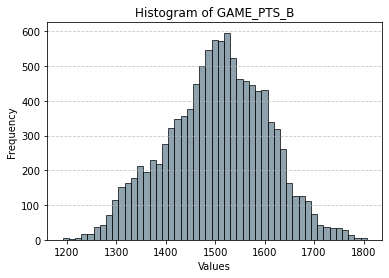

In [29]:
import matplotlib.pyplot as plt

plt.hist(final_df['ELO_A'], bins='auto', alpha=0.7, color='#607c8e', edgecolor='black')

# Customize the plot
plt.title(f'Histogram of {col}')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()